In [1]:
import sys
# update the pip package installer
!{sys.executable} -m pip install --upgrade --user pip
# install required packages
!{sys.executable} -m pip install --upgrade --user uproot awkward vector matplotlib

In [146]:
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import infofile # local file containing cross-sections, sums of weights, dataset IDs
import newinfofile #neue Infofile

In [147]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address
new_tuple_path = "/project/etp1/dkoch/ATLASOpenData-test/"

In [198]:
samples = {

   'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
   },

    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        # 'list' : ['Zee','Zmumu','ttbar_lep'],
        'list': ['ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

     r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
      'color' : "#ff0000" # red
    },

     r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    },

}

new_samples = {
  
    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        'list' : 
        [
            'user.garciarm.39227472._000001.output_ntup.root', 
            
            'user.garciarm.39227472._000002.output_ntup.root',
#             'user.garciarm.39227472._000003.output_ntup.root',
#             'user.garciarm.39227472._000004.output_ntup.root',
#             'user.garciarm.39227472._000005.output_ntup.root',
#            #bem 6 und 7 15 sind nicht da!
#             'user.garciarm.39227472._000008.output_ntup.root',
#             'user.garciarm.39227472._000009.output_ntup.root',
#             'user.garciarm.39227472._000010.output_ntup.root',
#             'user.garciarm.39227472._000011.output_ntup.root',
#             'user.garciarm.39227472._000012.output_ntup.root',
#             'user.garciarm.39227472._000013.output_ntup.root',
#             'user.garciarm.39227472._000014.output_ntup.root',
#    #und  15 sind nicht da!
#             'user.garciarm.39227472._000016.output_ntup.root',
#             'user.garciarm.39227472._000017.output_ntup.root',
#             'user.garciarm.39227472._000018.output_ntup.root',
#             'user.garciarm.39227472._000019.output_ntup.root',
#             'user.garciarm.39227472._000020.output_ntup.root'
        ],
        'color' : "#00ff00" # GRUN
    },
}


In [199]:
MeV = 0.001
GeV = 1.0

In [200]:
def get_data_from_new_files():
    new_data = {} # define empty dictionary to hold awkward arrays
    for s in new_samples: # loop over samples
        print('Processing NEW '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in new_samples[s]['list']: # loop over each file
           # if s == 'data': prefix = "Data/" # Data prefix  (Daten sind ausgeschlossen => unnotig?)
            #else: #ttbar prefix
            prefix = "ttbar-samples-with-weights/" #wir kümmern uns nur um ttbar
            fileString = new_tuple_path+prefix+val # file name to open  
            print(fileString, val) 
            temp = read_file(fileString,val,treename="analysis") # call the function read_file defined below
            frames.append(temp) # append array returned from read_file to list of awkward arrays
        new_data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    
    return new_data # return dictionary of awkward arrays

In [201]:
def get_data_from_old_files():
   
    data = {} # define empty dictionary to hold awkward arrays
    frames = [] # define empty list to hold data
   # for s in samples: # loop over samples
       # print('Processing '+s+' samplesS') # print which sample
       
    for val in samples[r'Background $Z,t\bar{t}$']['list']: # loop over each file
            #if s == 'data': prefix = "Data/" # Data prefix
          #  else: # MC prefix
        prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
        fileString = tuple_path+prefix+val+".4lep.root" # file name to open
        temp = read_old_file(fileString,val) # call the function read_file defined below
        frames.append(temp) # append array returned from read_file to list of awkward arrays
    data[r'Background $Z,t\bar{t}$'] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    
    return data # return dictionary of awkward arrays


In [202]:
def get_data_from_new_files2():
    new_data = {} # define empty dictionary to hold awkward arrays
    frames = [] # define empty list to hold data
    for val in new_samples[r'Background $Z,t\bar{t}$']['list']:
        
        prefix = "ttbar-samples-with-weights/"
        fileString = new_tuple_path+prefix+val # file name to open
        print(fileString, val)
        temp = read_file(fileString,val,treename="analysis") # call the function read_file defined below
        frames.append(temp) # append array returned from read_file to list of awkward arrays
    new_data[r'Background $Z,t\bar{t}$'] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
        
    return new_data # return dictionary of awkward arrays

In [203]:
def calc_new_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.ScaleFactor_PILEUP
        * events.ScaleFactor_ELE
        * events.ScaleFactor_MUON 
        #* events.ScaleFactor_LepTRIGGER = 1 #keine LepTrigger bei tree.keys()
    )

In [204]:
def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON 
        * events.scaleFactor_LepTRIGGER
    )

In [205]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [206]:
def get_new_xsec_weight(sample):
    info = newinfofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]) #*1000 to go from fb-1 to pb-1  ?red_eff stets = 1 ?
    return xsec_weight # return cross-section weight

In [207]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_e):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_e})
    
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    
  
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV

In [208]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
    # Ensure lep_charge is at least 2D
    #lep_charge = ak.to_regular(lep_charge)
    return ak.num(lep_charge) > 4
    # Initialize a mask with all False (i.e., keep all events initially)
    mask = np.zeros(len(lep_charge), dtype=bool)
    
    # Iterate over events to apply the cut
    for i, charges in enumerate(lep_charge):
        if len(charges) >= 4:
            if np.sum(charges[:4]) != 0:
                mask[i] = True  # Mark event for exclusion if sum of charges is not zero
        else:
            mask[i] = True  # Mark event for exclusion if fewer than 4 leptons
    
    return mask

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    return (sum_lep_type != 44) #& (sum_lep_type != 48) & (sum_lep_type != 52)check, ob. die gleich wsl sind.

In [209]:
def read_old_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessingS via read_file function the sample: " + sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample
    
    # open the tree called mini using a context manager (will automatically close files/resources)
    with uproot.open(path + ":mini") as tree:
        numevents = tree.num_entries # number of events
        if 'data' not in sample: 
            xsec_weight = get_xsec_weight(sample) # get cross-section weight
        for data in tree.iterate(['lep_pt','lep_eta','lep_phi', #data is hier keys
                                  'lep_E','lep_charge','lep_type', 
                                  # add more variables here if you make cuts on them 
                                  'mcWeight','scaleFactor_PILEUP',
                                  'scaleFactor_ELE','scaleFactor_MUON',
                                  'scaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                                 library="ak", # choose output type as awkward array
                                 entry_stop=numevents*fraction): # process up to numevents*fraction

            nIn = len(data) # number of events in this batch

            if 'data' not in sample: # only do this for Monte Carlo simulation files
                # multiply all Monte Carlo weights and scale factors together to give total weight
                data['totalWeight'] = calc_weight(xsec_weight, data)

            # cut on lepton charge using the function cut_lep_charge defined above
            data = data[~cut_lep_charge(data.lep_charge)]#lep charge sind cut damit weniger

            # cut on lepton type using the function cut_lep_type defined above
            data = data[~cut_lep_type(data.lep_type)]

            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            data['mllll'] = calc_mllll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)

            # array contents can be printed at any stage like this
            #print(data)

            # array column can be printed at any stage like this
            #print(data['lep_pt'])

            # multiple array columns can be printed at any stage like this
            #print(data[['lep_pt','lep_eta']])

            nOut = len(data) # number of events passing cuts in this batch
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) # return array containing events passing all cuts

In [210]:
def read_file(path,sample, treename="analysis"):
    
    
    start = time.time() # start the clock
    print("\tProcessing: " + sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample
    
    # open the tree called mini using a context manager (will automatically close files/resources)
    with uproot.open(path + ":" + treename) as tree: #webseite geöffnet
        numevents = tree.num_entries # number of events
        #if 'data' not in sample: alle Daten sind simuliert?
        xsec_weight = get_new_xsec_weight(sample) # get cross-section weight
        for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                                  'lep_e','lep_charge','lep_type', 
                                  #add more variables here if you make cuts on them 
                                  'mcWeight',
                                  'ScaleFactor_PILEUP',
                                  'ScaleFactor_ELE',
                                  'ScaleFactor_MUON',
                                  #'ScaleFactor_LepTRIGGER' # variables to calculate Monte Carlo weight
                                  ],
                                 library="ak", # choose output type as awkward array
                                 entry_stop=numevents):# fraction = 1 zur Zeit *fraction): # process up to numevents*fraction

            nIn = len(data) # number of events in this batch

            #if 'data' not in sample: # only do this for Monte Carlo simulation files
                # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = calc_new_weight(xsec_weight, data)

            # cut on lepton charge using the function cut_lep_charge defined above
            data = data[~cut_lep_charge(data.lep_charge)]

            # cut on lepton type using the function cut_lep_type defined above
            data = data[~cut_lep_type(data.lep_type)]

            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            data['mllll'] = calc_mllll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_e)

            # array contents can be printed at any stage like this
            #print(data)

            # array column can be printed at any stage like this
            #print(data['lep_pt'])

            # multiple array columns can be printed at any stage like this
            #print(data[['lep_pt','lep_eta']])

            nOut = len(data) # number of events passing cuts in this batch
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) # return array containing events passing all cuts


In [211]:
start = time.time() # time at start of whole processing
data = get_data_from_new_files2() # process all files
data_old = get_data_from_old_files() #daten von alten datensatzen wie üblich aber jz nur ttbar

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

/project/etp1/dkoch/ATLASOpenData-test/ttbar-samples-with-weights/user.garciarm.39227472._000001.output_ntup.root user.garciarm.39227472._000001.output_ntup.root
	Processing: user.garciarm.39227472._000001.output_ntup.root
		 nIn: 2040025,	 nOut: 	297	 in 71.6s
		 nIn: 942476,	 nOut: 	150	 in 105.0s
/project/etp1/dkoch/ATLASOpenData-test/ttbar-samples-with-weights/user.garciarm.39227472._000002.output_ntup.root user.garciarm.39227472._000002.output_ntup.root
	Processing: user.garciarm.39227472._000002.output_ntup.root
		 nIn: 2041369,	 nOut: 	324	 in 70.8s
		 nIn: 899717,	 nOut: 	146	 in 102.7s
	ProcessingS via read_file function the sample: ttbar_lep
		 nIn: 1,	 nOut: 	0	 in 0.4s
		 nIn: 1,	 nOut: 	0	 in 0.4s
		 nIn: 1,	 nOut: 	0	 in 0.5s
		 nIn: 1,	 nOut: 	0	 in 0.6s
		 nIn: 1,	 nOut: 	0	 in 0.6s
		 nIn: 1,	 nOut: 	0	 in 0.7s
		 nIn: 1,	 nOut: 	0	 in 0.7s
		 nIn: 1,	 nOut: 	0	 in 0.8s
		 nIn: 1,	 nOut: 	1	 in 0.9s
		 nIn: 1,	 nOut: 	0	 in 0.9s
		 nIn: 1,	 nOut: 	0	 in 1.0s
		 nIn: 1,

In [172]:
data.keys()
data

{'Background $Z,t\\bar{t}$': <Array [{lep_pt: [...], ...}, ..., {...}] type='917 * {lep_pt: var * float3...'>}

In [173]:
data_old.keys()
data_old
#len(data_old) =1 ?

{'Background $Z,t\\bar{t}$': <Array [{lep_pt: [...], ...}, ..., {...}] type='35 * {lep_pt: var * float32...'>}

In [89]:

import numpy as np
import matplotlib.pyplot as plt

def plot_data(data):
    # Assuming data is a dictionary
  
    background_x = data['Background $Z,t\\bar{t}$']

    # Plotting
    plt.hist(signal_x, bins=100, color='blue', alpha=0.5, label='Signal')
    plt.hist(background_x, bins=100, color='red', alpha=0.5, label='Background')

    plt.xlabel('$m_{llll}$ (GeV)')
    plt.ylabel('Events')
    plt.title('Distribution of $m_{llll}$')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the new data structure
plot_data(data)


   
    


NameError: name 'signal_x' is not defined

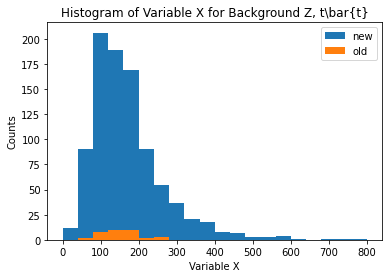

In [235]:



plt.hist(data['Background $Z,t\\bar{t}$']['mllll']*1000, bins=20, range=(0,800), label="new")
plt.hist(data_old['Background $Z,t\\bar{t}$']['mllll'], bins=20, range=(0,800), label="old")
   

plt.xlabel('Variable X')
plt.ylabel('Counts')
plt.legend()
plt.title('Histogram of Variable X for Background Z, t\\bar{t}')
plt.show()


(array([3., 5., 3., 8., 4., 4., 3., 2., 1., 2.]),
 array([ 66.42734528,  86.8657074 , 107.30406952, 127.74243164,
        148.18080139, 168.61915588, 189.05752563, 209.49588013,
        229.93424988, 250.37260437, 270.81097412]),
 <BarContainer object of 10 artists>)

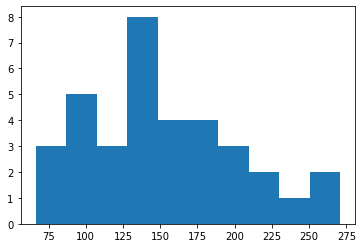

In [213]:
plt.hist(data_old['Background $Z,t\\bar{t}$']['mllll'])

(array([183., 427., 195.,  64.,  27.,  11.,   6.,   1.,   2.,   1.]),
 array([0.00964816, 0.09703831, 0.18442847, 0.27181861, 0.35920876,
        0.44659892, 0.53398907, 0.62137926, 0.70876938, 0.79615957,
        0.88354969]),
 <BarContainer object of 10 artists>)

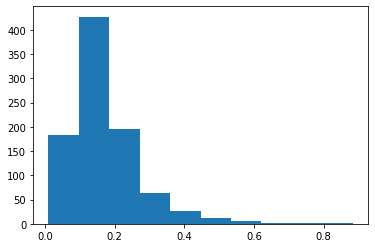

In [215]:
plt.hist(data['Background $Z,t\\bar{t}$']['mllll'])

In [116]:
data['Background $Z,t\\bar{t}$']['mllll'] 



<Array [0.124, 0.29, 0.173, ..., 0.112, 0.42, 0.0895] type='917 * float32'>

In [124]:
data_old['Background $Z,t\\bar{t}$']['mllll'] 

<Array [136, 174, 82.8, 92.3, ..., 93.7, 96.2, 164, 141] type='35 * float32'>

In [96]:
background_data = new_samples[r'Background $Z,t\bar{t}$'] 
background_data

{'list': ['user.garciarm.39227472._000001.output_ntup.root',
  'user.garciarm.39227472._000002.output_ntup.root',
  'user.garciarm.39227472._000003.output_ntup.root',
  'user.garciarm.39227472._000004.output_ntup.root',
  'user.garciarm.39227472._000005.output_ntup.root',
  'user.garciarm.39227472._000008.output_ntup.root',
  'user.garciarm.39227472._000009.output_ntup.root',
  'user.garciarm.39227472._000010.output_ntup.root',
  'user.garciarm.39227472._000011.output_ntup.root',
  'user.garciarm.39227472._000012.output_ntup.root',
  'user.garciarm.39227472._000013.output_ntup.root',
  'user.garciarm.39227472._000014.output_ntup.root',
  'user.garciarm.39227472._000016.output_ntup.root',
  'user.garciarm.39227472._000017.output_ntup.root',
  'user.garciarm.39227472._000018.output_ntup.root',
  'user.garciarm.39227472._000019.output_ntup.root',
  'user.garciarm.39227472._000020.output_ntup.root'],
 'color': '#00ff00'}

In [117]:
data_old.keys()

dict_keys(['Background $Z,t\\bar{t}$'])

In [122]:
background_data_old = samples[r'Background $Z,t\bar{t}$']
background_data_old

{'list': ['ttbar_lep'], 'color': '#6b59d3'}

In [87]:
def plot_new_data(data):
    xmin = 80
    xmax = 250
    step_size = 5

    bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size)
    bin_centres = np.arange(start=xmin+step_size/2, stop=xmax+step_size/2, step=step_size)
    data_x,_ = np.histogram(data['Background $Z,t\\bar{t}$']['mllll'], bins=bin_edges)
    data_x_errors = 0
    
    signal_x = data[r'Background $Z,t\bar{t}$']
    signal_weights = data['Background $Z,t\\bar{t}$'].totalWeight
    signal_color = new_samples['Background $Z,t\\bar{t}$']['color']
    
    mc_x = [data[s]['mllll'] for s in new_samples ]
    mc_weights = [data[s].totalWeight for s in new_samples ]
    mc_colors = [samples[s]['color'] for s in new_samples ]
    mc_labels = [s for s in new_samples]
    
    main_axes = plt.gca()

    mc_heights = main_axes.hist(mc_x, bins=bin_edges, weights=mc_weights, stacked=True, color=mc_colors, label=mc_labels)
    mc_x_tot = mc_heights[0][-1]
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, weights=signal_weights, color=signal_color, label=r'Signal ($m_H$ = 125 GeV)')
    main_axes.set_xlim(left=xmin, right=xmax)
    
   
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]', fontsize=13, x=1, horizontalalignment='right')
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV', y=1, horizontalalignment='right')
    main_axes.set_ylim(bottom=0, top=np.amax(data_x)*1.6)




   
    main_axes.legend(frameon=False)

    return


ValueError: cannot convert to RegularArray because subarray lengths are not regular (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-34/awkward-cpp/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

This error occurred while calling

    ak.to_numpy(
        <Array [{lep_pt: [...], ...}, ..., {...}] type='52 * {lep_pt: var *...'>
        allow_missing = True
    )

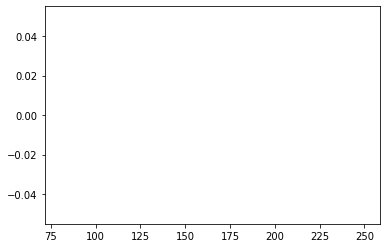

In [88]:
plot_new_data(data)

KeyError: 'Signal ($m_H$ = 125 GeV)'